# 50K Project - Segmentation Study

### Joseph Harvey, July 2021



In [84]:
#import needed classes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

We start by importing the data.

In [85]:
df_train = pd.read_csv('au_train.csv', skipinitialspace = True)

Let's take a quick look at that dataframe:

In [86]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Let's begin by cleaning up some features to make them easier to interpret in plots. Let's reduce the categories within education to 'Pre-HS-grad', 'HS-grad', 'Some-college', 'Assoc', 'Bachelors', 'Masters', 'Prof-school', and 'Doctorate'. We lump everything together that is prior to high school graduation, and we combine the two types of Associate degree.

We also clean up the marital-status feature by combining 'Married-civ-spouse' and 'Married-AF-spouse' into one 'Married' category.

In [87]:
#cleaning up features

#Simplyfying education in training set
df_train['education']=np.where(df_train['education'] =='Preschool', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='1st-4th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='5th-6th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='7th-8th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='9th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='10th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='11th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='12th', 'Pre-HS-grad', df_train['education'])
df_train['education']=np.where(df_train['education'] =='Assoc-voc', 'Assoc', df_train['education'])
df_train['education']=np.where(df_train['education'] =='Assoc-acdm', 'Assoc', df_train['education'])

#Simplyfying marital-status
df_train = df_train.replace('Married-civ-spouse', 'Married')
df_train = df_train.replace('Married-AF-spouse', 'Married')

We begin with some exploratory data visualization. 
We first look at the counts of the two income classes (<=50K and >50K).

<=50K    24720
>50K      7841
Name: class, dtype: int64


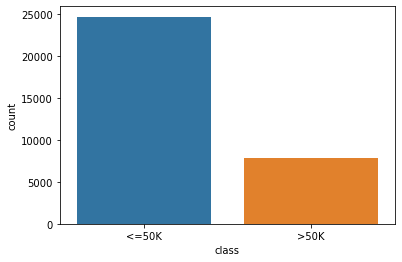

In [88]:
print(df_train['class'].value_counts())
sns.set_context(rc = {'patch.linewidth': 0.0})
sns.countplot(x="class", data=df_train)

We have imbalanced classes, with about 3x more examples of the <=50k class! Let's keep that in mind as we explore the data. From the modeling problem, we know that the challenge with this dataset is correctly identifying >50K cases (the logistic regression model correctly identified only about half of these). Maybe some data visualization can shed some light on this and offer some potential solutions.

To start, we'll look at the breakdown by class within the categories of several categorical variables. Rather than plotting the count of each class within each category, we plot the proportion of classes in each category.

Text(0, 0.5, 'fraction of category')

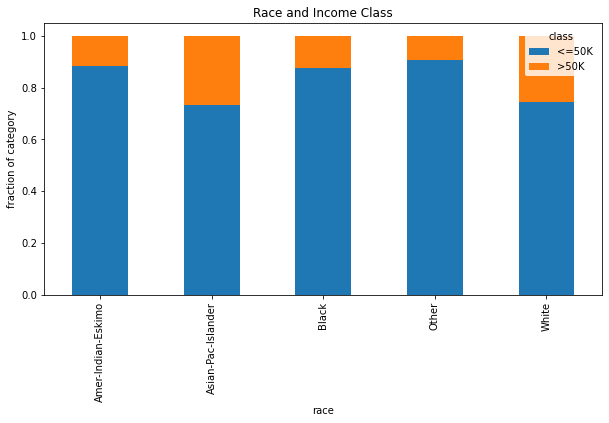

In [89]:
#race and income class
table=pd.crosstab(df_train['race'], df_train['class'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (10,5), stacked=True)
plt.title('Race and Income Class')
plt.ylabel('fraction of category')

For for all races a <=50k class is more likely, with whites and Asian/Pacific Islanders having a slightly greater proportion of the >50K class. Still, this doesn't look like an extremely valuable feature.

Text(0, 0.5, 'fraction of category')

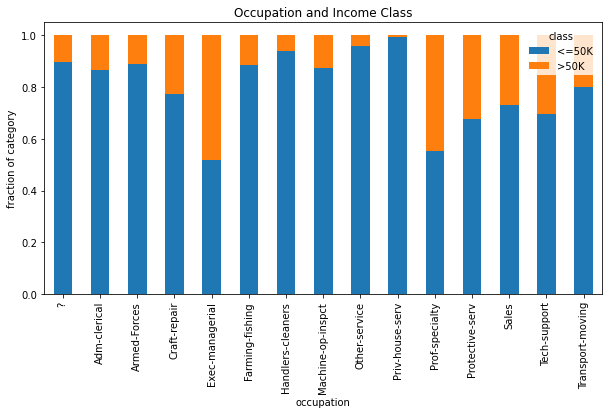

In [90]:
#occupation and income class 
table=pd.crosstab(df_train['occupation'], df_train['class'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (10,5), stacked=True)
plt.title('Occupation and Income Class')
plt.ylabel('fraction of category')

Occupation, as expected, shows seperation between high-paying jobs like Executive/managerial and professional/speciality jobs and lower paying jobs like service, farming, and private house servants. Interestingly, both executive/managerial and professional/speciality jobs have slightly less than half in the >50K category.

Text(0, 0.5, 'fraction of category')

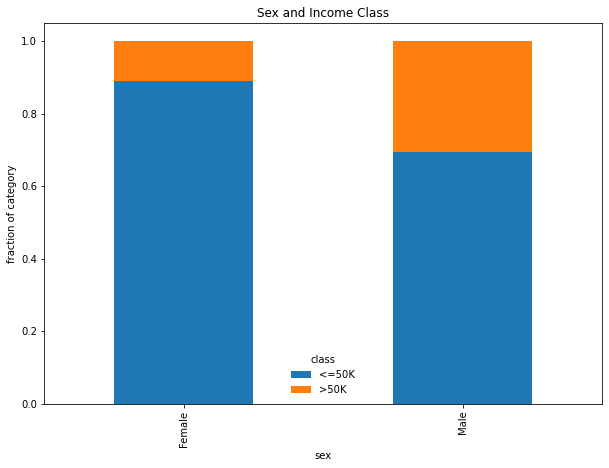

In [91]:
#sex and income class
table=pd.crosstab(df_train['sex'], df_train['class'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (10,7), stacked=True)
plt.title('Sex and Income Class')
plt.ylabel('fraction of category')

There is a higher proportion of men than women who make >50K; this may be a good feature to include. Still, a man is much more likely to make <=50K than >50K. 

Text(0, 0.5, 'count')

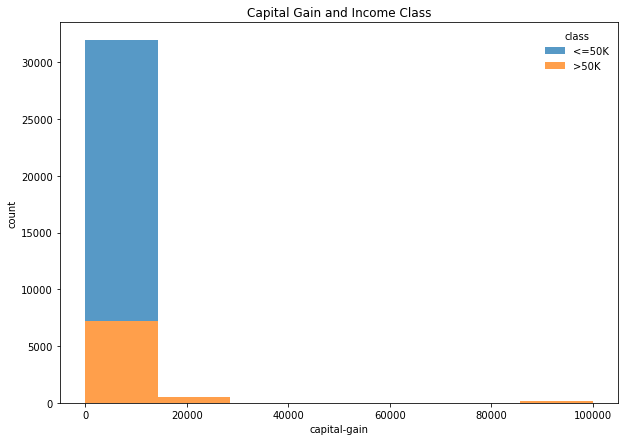

In [92]:
#capital gain
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(df_train, x='capital-gain', bins = 7, hue='class', multiple="stack")
plt.title('Capital Gain and Income Class')
plt.ylabel('count')

It is unclear from this graph whether capital gains is a valuable feature or not. As a guess, it's probably not terribly valuable at improving classification of >50K cases, as there are many >50K cases with 0 capital gains. (I tried adding capital gains to the features in the logistic regression, and it did not improve accuracy very much.)

Text(0, 0.5, 'count')

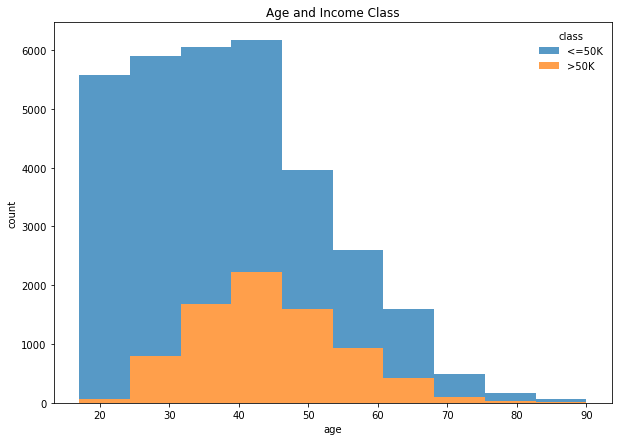

In [93]:
#age and income class
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(df_train, x='age', bins = 10, hue='class', multiple="stack")
plt.title('Age and Income Class')
plt.ylabel('count')

Age is clearly a valuable feature - as age increases up to about 60, the proportion of people in the >50K increases. The value of this feature was confirmed by logistic regression coefficient plot.

Text(0, 0.5, 'count')

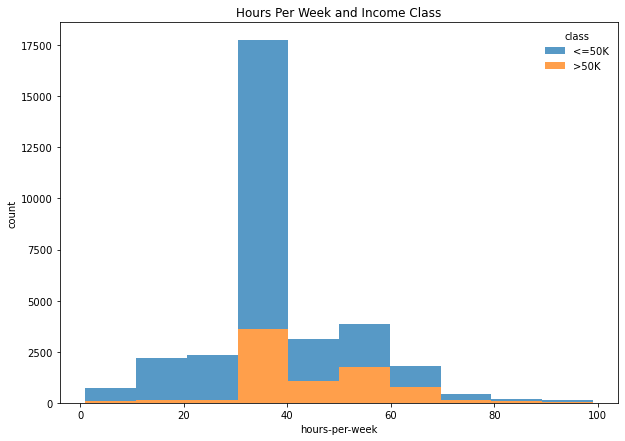

In [94]:
#hours worked and income class
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(df_train, x='hours-per-week', bins = 10, hue='class', multiple="stack")
plt.title('Hours Per Week and Income Class')
plt.ylabel('count')

The more hours a person works, the more likely they are to make >50K, as expected.

Text(0, 0.5, 'fraction of category')

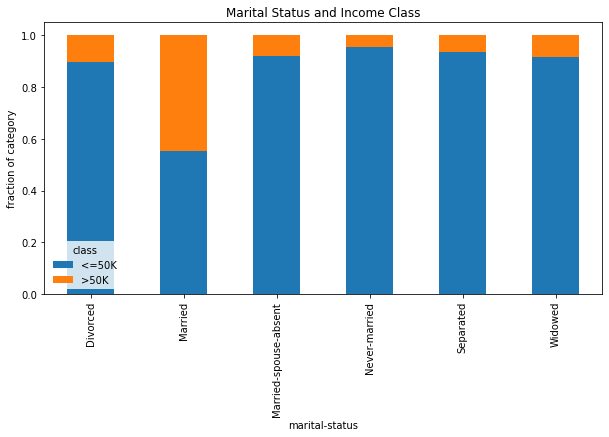

In [95]:
#marital status and income class
table=pd.crosstab(df_train['marital-status'], df_train['class'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (10,5), stacked=True)
plt.title('Marital Status and Income Class')
plt.ylabel('fraction of category')

This plot reveals that those who are married are much more likely to make >50K. This is probably a valuable feature.

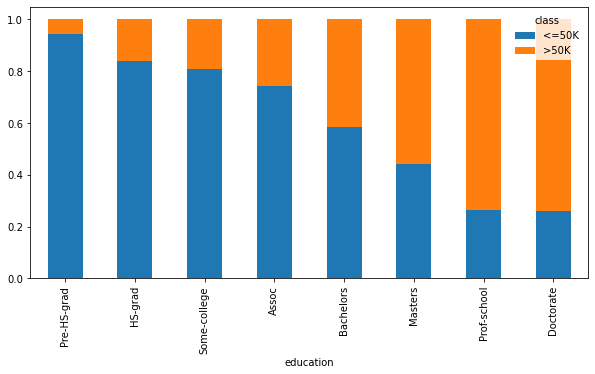

In [96]:
#education and income class
table=pd.crosstab(df_train['education'], df_train['class'])
order = ['Pre-HS-grad', 'HS-grad', 'Some-college', 'Assoc', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']
table = table.reindex(order, axis = 'rows')
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (10,5), sort_columns=False, stacked=True)

As education level increases, one is more likely to make >50K. Beginning with masters on up, one is more likely to make >50K than <=50K. Education is clearly a very valuable feature which separates the two classes.  

Now let's see if we can find interesting correlations between variables other than income class.

Text(0, 0.5, 'fraction of category')

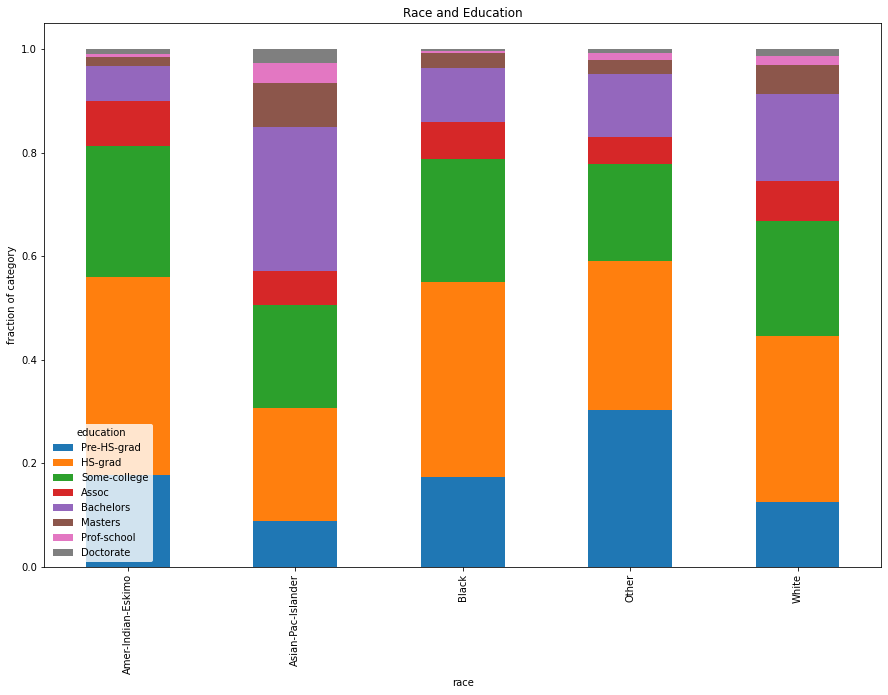

In [97]:
#race and education
table=pd.crosstab(df_train['race'], df_train['education'])
order = ['Pre-HS-grad', 'HS-grad', 'Some-college', 'Assoc', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']
table = table.reindex(order, axis = 'columns')
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (15,10), stacked=True)
plt.title('Race and Education')
plt.ylabel('fraction of category')

This graph shows that Asian/Pacific Islanders have significantly more masters, doctorates, and bachelors than other races.

Text(0, 0.5, 'fraction of category')

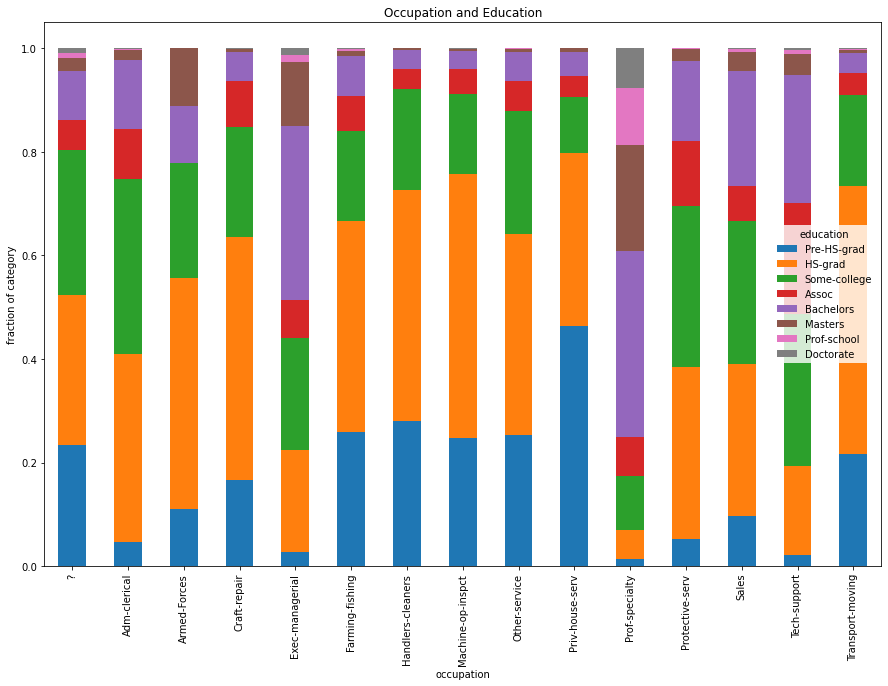

In [98]:
#occupation and education
table=pd.crosstab(df_train['occupation'], df_train['education'])
order = ['Pre-HS-grad', 'HS-grad', 'Some-college', 'Assoc', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']
table = table.reindex(order, axis = 'columns')
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (15,10), stacked=True)
plt.title('Occupation and Education')
plt.ylabel('fraction of category')

This plot indicates that executive/managerial, professional/speciality, and tech support positions are correlated with higher levels of education. 

Text(0, 0.5, 'fraction of category')

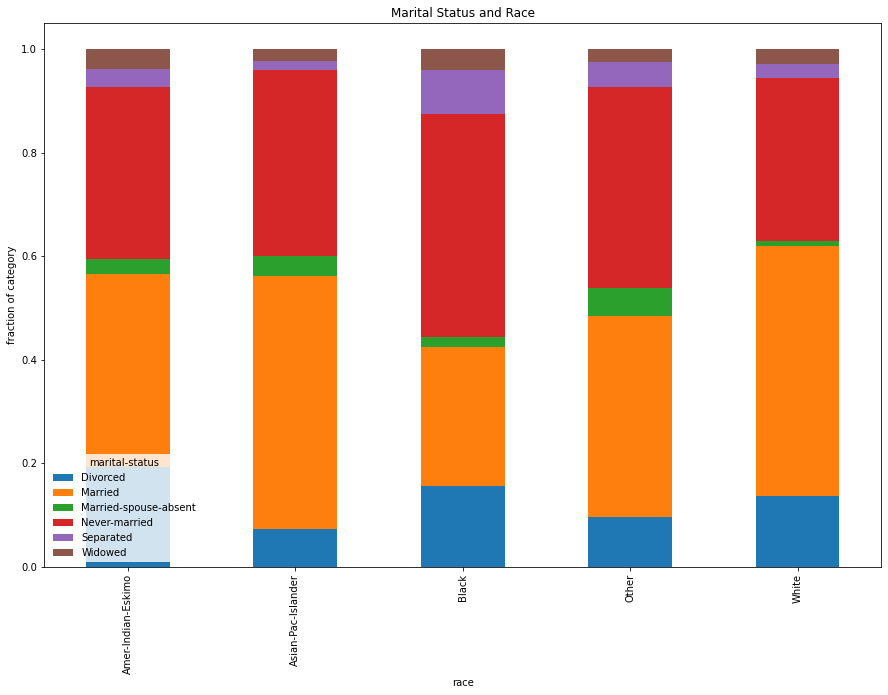

In [99]:
#marital status, race
table=pd.crosstab(df_train['race'], df_train['marital-status'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize = (15,10), stacked=True)
plt.title('Marital Status and Race')
plt.ylabel('fraction of category')

This plot shows that whites and Asian/Pacific Islanders have somewhat higher proportions of the 'Married' category than other groups.

This data exploration and visualization lends support to the value of the features used in the logistic regression and random forest in the classification notebook.